In [ ]:
!pip install torch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [17]:
# convert data into tensor of 4D (images, Heights, Weights, Color Channel)
transform = transforms.ToTensor()

In [18]:
# Train Data
train_data = datasets.MNIST(
    root= "/cnn_data",
    download = True,
    train = True,
    transform= transform
)

In [19]:
# Test Data
test_data = datasets.MNIST(
    root= "/cnn_data",
    download = True,
    train = False,
    transform= transform
)

In [20]:
print(train_data, test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [21]:
# Create a small batch size for images
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = True)

In [22]:
# Defining Convolutional Model
class CNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1,)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):
    X = f.relu(self.conv1(x))
    X = f.max_pool2d(X,2,2)
    X = f.relu(self.conv2(X))
    X = f.max_pool2d(X,2,2)
    X = f.relu(self.fc1(X.view(-1,5*5*16)))
    x = f.relu(self.fc2(X))
    X = self.fc3(x)

    return f.log_softmax(X, dim = 1)

In [23]:
# Create an Instance of our model
torch.manual_seed(41)
model = CNNModel()
print(model.parameters)

<bound method Module.parameters of CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>


In [24]:
print(model.eval())

CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [25]:
# Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # Smaller the learning rate, longer it takes to train a model

In [26]:
import time
start_time = time.time()

# Creates to variables to track things
epochs = 5
train_loss = []
test_loss = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # Start our batches = 1
    y_pred = model(X_train)  # Forward propagation
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data,1)[1] # Add up the number of correct predictions, Indexed off the first point.
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch.
    trn_corr += batch_corr

    # update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print(f'epoch: {i} batch: {b} loss: {loss.item()}')

  train_loss.append(loss.detach().numpy())
  train_correct.append(trn_corr)


  # TEST
  with torch.no_grad():
    for(b, (X_test, y_test)) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_loss.append(loss.detach().numpy())
  test_correct.append(tst_corr)

current_time = time.time()
total_time = current_time - start_time
print(f"Training time : {total_time/60} minutes")

epoch: 0 batch: 600 loss: 0.1599934995174408
epoch: 0 batch: 1200 loss: 0.18979528546333313
epoch: 0 batch: 1800 loss: 0.5580862760543823
epoch: 0 batch: 2400 loss: 0.2070152312517166
epoch: 0 batch: 3000 loss: 0.006888664327561855
epoch: 0 batch: 3600 loss: 0.33112621307373047
epoch: 0 batch: 4200 loss: 0.004664934705942869
epoch: 0 batch: 4800 loss: 0.0020317500457167625
epoch: 0 batch: 5400 loss: 0.06558699160814285
epoch: 0 batch: 6000 loss: 0.000513441045768559
epoch: 1 batch: 600 loss: 0.022129502147436142
epoch: 1 batch: 1200 loss: 0.00910872407257557
epoch: 1 batch: 1800 loss: 0.0012459950521588326
epoch: 1 batch: 2400 loss: 0.0027207969687879086
epoch: 1 batch: 3000 loss: 9.058915020432323e-05
epoch: 1 batch: 3600 loss: 0.006649290211498737
epoch: 1 batch: 4200 loss: 0.0005154887912794948
epoch: 1 batch: 4800 loss: 0.005008358974009752
epoch: 1 batch: 5400 loss: 0.00044716932461597025
epoch: 1 batch: 6000 loss: 0.000558710191398859
epoch: 2 batch: 600 loss: 0.04929005354642868

In [27]:
train_correct

[tensor(56256), tensor(58847), tensor(59175), tensor(59371), tensor(59455)]

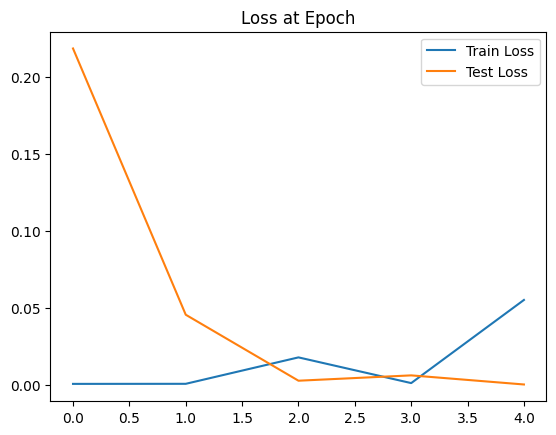

In [28]:
# Graph the loss at epoch
plt.plot(train_loss, label = "Train Loss")
plt.plot(test_loss, label = "Test Loss")
plt.title("Loss at Epoch")
plt.legend()

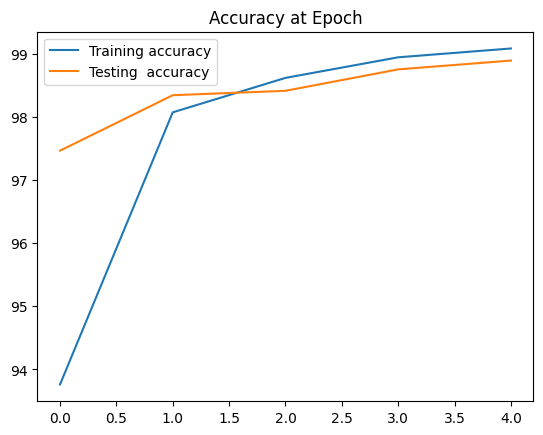

In [32]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = "Training accuracy")
plt.plot([t/100 for t in test_correct], label = "Testing  accuracy")
plt.title("Accuracy at Epoch")
plt.legend()
plt.show()

In [36]:
# accuracy for this model
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

Test accuracy: 98.900%


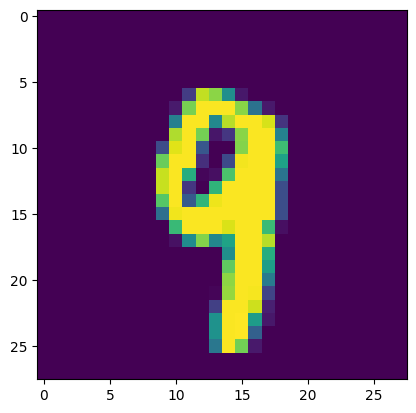

In [50]:
plt.imshow(test_data[4143][0][0])

In [57]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0][0].view(1,1,28,28))

In [58]:
print(new_prediction.argmax())

tensor(9)


In [59]:
# Saving the model as cnn_model.pt for MNIST
torch.save(model.state_dict(), "cnn_model.pt")

In [61]:
# Load the model
model1 = CNNModel()
model1.load_state_dict(torch.load('cnn_model.pt'))  # for using weight s

<All keys matched successfully>

In [62]:
model2 = torch.load("cnn_model.pt")